In [1]:
import numpy as np
import pandas as pd
import prophet
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from copy import deepcopy

# Prophet models on timeseries

Prophet is a [package from meta](https://peerj.com/preprints/3190/). The signal model is a [Generalised Additive Model](https://en.wikipedia.org/wiki/Generalized_additive_model), with four components:
- a trend component (saturated growth or piecewise linear)
- a seasonal component built out of global sinusoids
- a holiday component built out of indicator functions
- a noise component

This notebook presents some simple and sanity checking efforts on applying this signal model for predictive and forecasting purposes.

## Periodic signals

As a test case, consider a sinusoid with additive noise.

### Signal generation

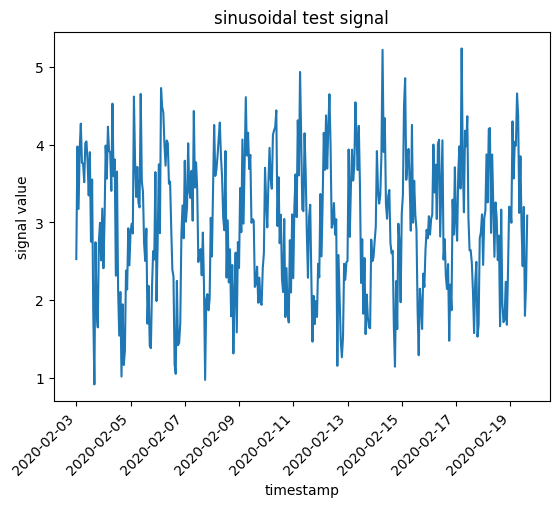

In [2]:
n_sample = 400
w_f = 2.0 * np.pi / 24.0
s_sin = 3 + np.sin([x * w_f for x in range(n_sample)]) + np.random.normal(loc=0.0, scale=0.5, size=n_sample)
t = [datetime(2020, 2, 3) + timedelta(hours=x) for x in range(n_sample)]
plt.plot(pd.DataFrame(
    {
        "data": s_sin, 
        "timestamp": t
    }).set_index("timestamp")
)
plt.xlabel("timestamp")
plt.xticks(rotation=45, ha="right")
plt.ylabel("signal value")
_ = plt.title("sinusoidal test signal")

In [3]:
df = pd.DataFrame(
    {
        "y": s_sin, 
        "ds": t
    }
)
len(df)

400

In [4]:
df_fit = df[:300]
len(df_fit)

300

## Modelling

### Basic modelling

Directly using the package out of the box on a noisy sinusoid seems to work pretty well.

In [5]:
model = prophet.Prophet()

In [6]:
model.fit(df_fit)

23:27:14 - cmdstanpy - INFO - Chain [1] start processing
23:27:14 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
df_pred = model.predict(
    pd.DataFrame(df["ds"])
)

In [8]:
df_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-03 00:00:00,2.955020,2.274463,3.530739,2.955020,2.955020,-0.055515,-0.055515,-0.055515,-0.055515,-0.055515,-0.055515,0.0,0.0,0.0,2.899505
1,2020-02-03 01:00:00,2.955228,2.579038,3.758150,2.955228,2.955228,0.238843,0.238843,0.238843,0.238843,0.238843,0.238843,0.0,0.0,0.0,3.194071
2,2020-02-03 02:00:00,2.955437,2.926591,4.113105,2.955437,2.955437,0.560923,0.560923,0.560923,0.560923,0.560923,0.560923,0.0,0.0,0.0,3.516360
3,2020-02-03 03:00:00,2.955645,3.142209,4.397604,2.955645,2.955645,0.800311,0.800311,0.800311,0.800311,0.800311,0.800311,0.0,0.0,0.0,3.755956
4,2020-02-03 04:00:00,2.955854,3.245264,4.499413,2.955854,2.955854,0.898907,0.898907,0.898907,0.898907,0.898907,0.898907,0.0,0.0,0.0,3.854761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2020-02-19 11:00:00,2.989486,2.640863,3.902671,2.988224,2.990899,0.309511,0.309511,0.309511,0.309511,0.309511,0.309511,0.0,0.0,0.0,3.298997
396,2020-02-19 12:00:00,2.989570,2.351384,3.611725,2.988288,2.991006,-0.012595,-0.012595,-0.012595,-0.012595,-0.012595,-0.012595,0.0,0.0,0.0,2.976975
397,2020-02-19 13:00:00,2.989654,2.152406,3.383970,2.988344,2.991108,-0.250921,-0.250921,-0.250921,-0.250921,-0.250921,-0.250921,0.0,0.0,0.0,2.738732
398,2020-02-19 14:00:00,2.989738,1.933181,3.182404,2.988410,2.991218,-0.439782,-0.439782,-0.439782,-0.439782,-0.439782,-0.439782,0.0,0.0,0.0,2.549956


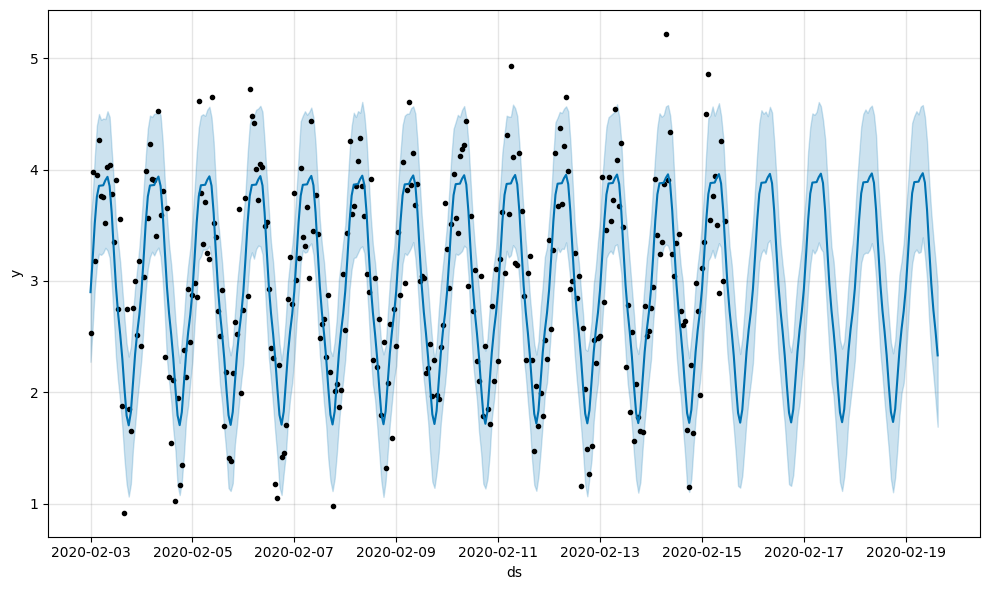

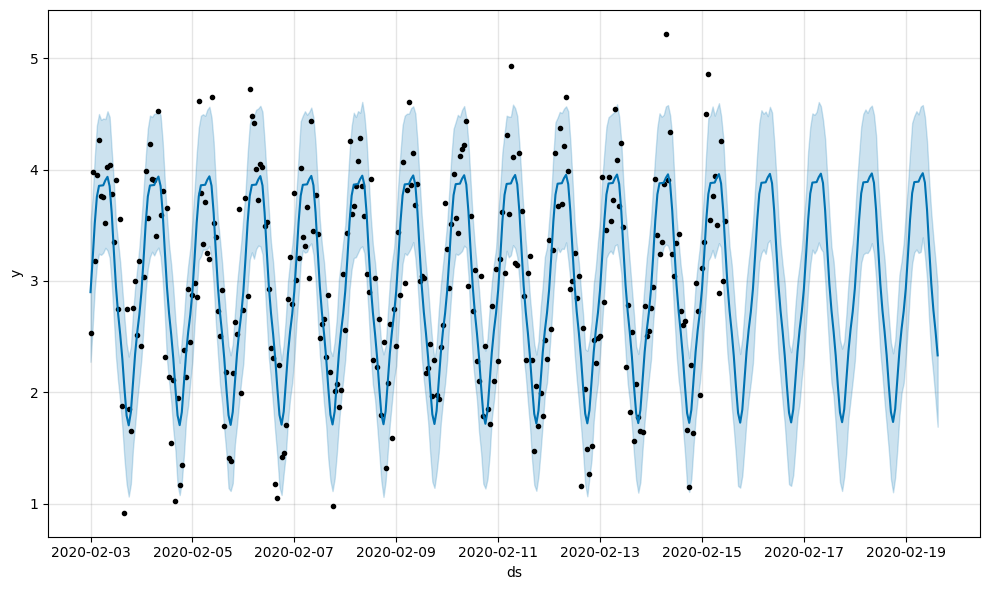

In [9]:
model.plot(df_pred)

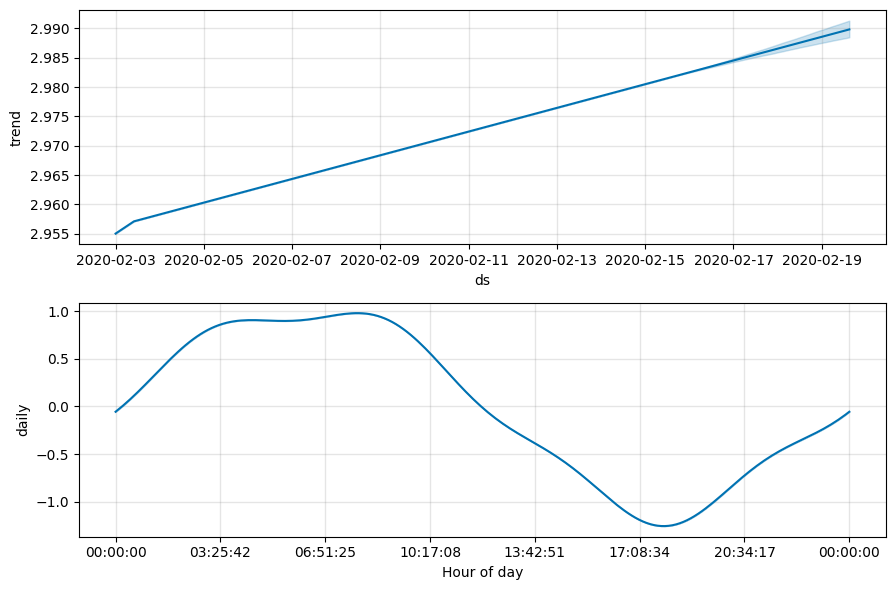

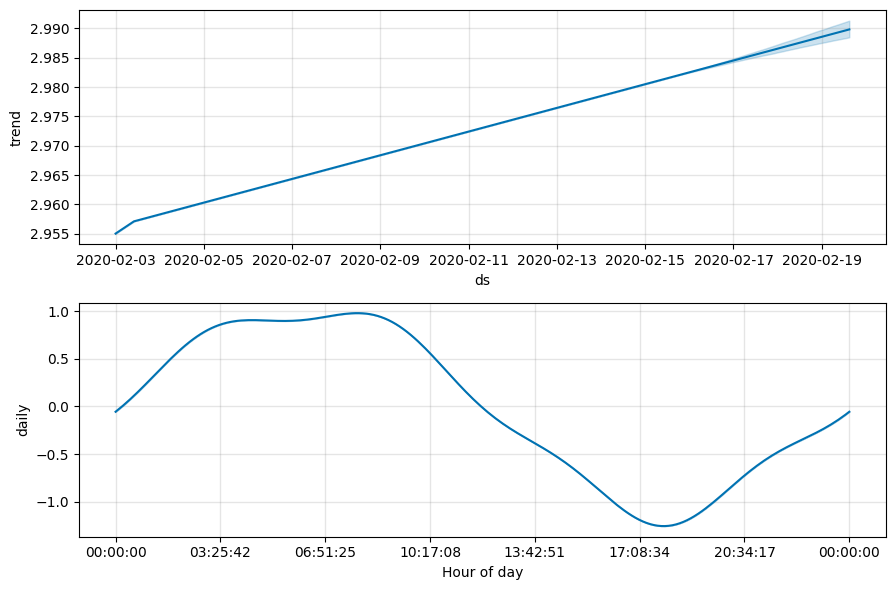

In [10]:
model.plot_components(df_pred)

In [20]:
def plot_prophet_results(df, n_fit, prophet_kwargs={}):
    df_fit = df[:n_fit]
    model = prophet.Prophet(**prophet_kwargs)
    model.fit(df_fit)
    df_pred = model.predict(pd.DataFrame(df["ds"]))
    
    plt.plot(df.set_index("ds"), label="original signal")
    plt.plot(df_pred["ds"], df_pred["yhat"], color="orange", label="prediction")
    plt.plot(df_pred["ds"][:n_fit], df_pred["yhat"][:n_fit], color="red", label="fitted values")
    plt.fill_between(df_pred["ds"], df_pred["yhat_lower"], df_pred["yhat_upper"], color=(0.01, 0.4, 0.6, 0.2), label=f"confidence interval")

    plt.legend(loc="upper left")
    plt.xlabel("timestamp")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("signal value")
    plt.title("Prophet modelling of signal")

23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:43 - cmdstanpy - INFO - Chain [1] done processing


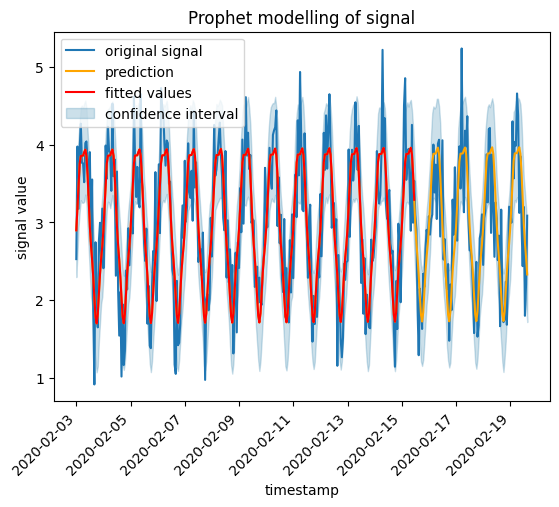

In [21]:
plot_prophet_results(df, 300)

### Datasets with NaNs or zeros 

Prophet seems to safely ignore nans.

The presence of zeros gives rise to long time-scale behaviour/interference. This is perhaps unsurprising given that the model is a GAM.

In [13]:
df_with_nans = deepcopy(df)
df_with_nans["y"][100:150] = np.nan

/tmp/ipykernel_89714/2246229399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_nans["y"][100:150] = np.nan


23:29:48 - cmdstanpy - INFO - Chain [1] start processing
23:29:48 - cmdstanpy - INFO - Chain [1] done processing


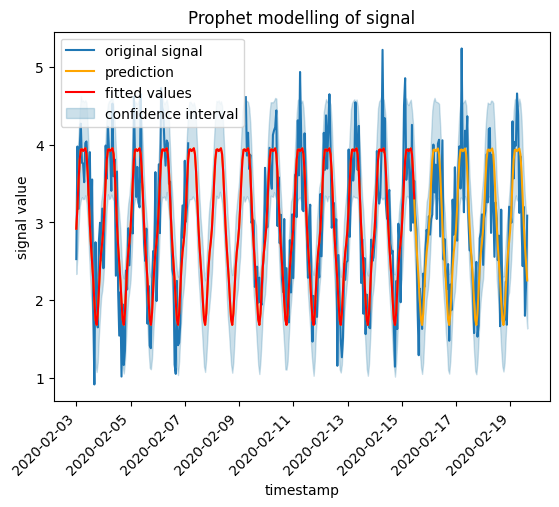

In [22]:
plot_prophet_results(df_with_nans, 300)

In [15]:
df_with_zeros = deepcopy(df)
df_with_zeros["y"][100:150] = 0.0

/tmp/ipykernel_89714/388340797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_zeros["y"][100:150] = 0.0


23:29:52 - cmdstanpy - INFO - Chain [1] start processing
23:29:52 - cmdstanpy - INFO - Chain [1] done processing


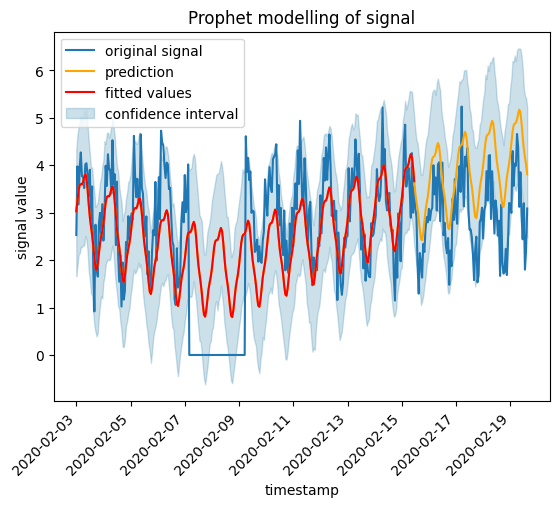

In [23]:
plot_prophet_results(df_with_zeros, 300)

## Periodic impulses

Begin a Generalised Additive Model, the fitting functions are smooth and global, meaning that spiky or impulsive behaviour gets smoothed out with default parameters (although this can effect can be reduced by upping the number of Fourier modes).

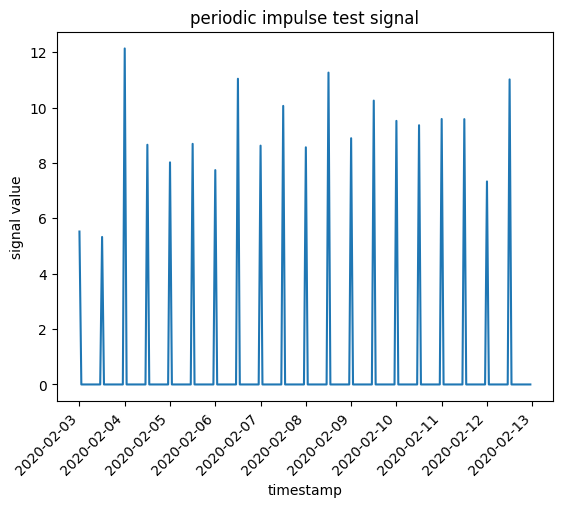

In [17]:
n_period = 20
period_samples = 12
n_sample = n_period * period_samples

s_periodic_impulse = np.zeros(n_sample)
s_periodic_impulse[::period_samples] = np.random.normal(loc=10, scale=2, size=n_period) 
t = [datetime(2020, 2, 3) + timedelta(hours=x) for x in range(n_sample)]

plt.plot(pd.DataFrame(
    {
        "data": s_periodic_impulse, 
        "timestamp": t
    }).set_index("timestamp")
)
plt.xlabel("timestamp")
plt.xticks(rotation=45, ha="right")
plt.ylabel("signal value")
_ = plt.title("periodic impulse test signal")

In [18]:
df_impulses = pd.DataFrame(
    {
        "y": s_periodic_impulse, 
        "ds": t
    }
)

23:58:39 - cmdstanpy - INFO - Chain [1] start processing
23:58:39 - cmdstanpy - INFO - Chain [1] done processing


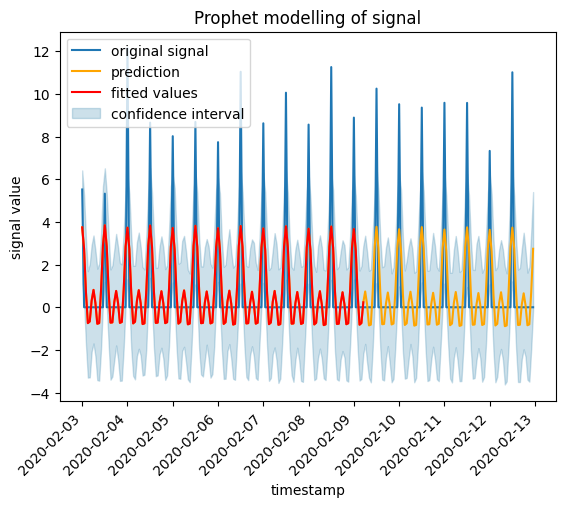

In [30]:
plot_prophet_results(df_impulses, 150)

The smoothing effect above can be remedied by increasing the number of Fourier modes.

23:58:45 - cmdstanpy - INFO - Chain [1] start processing
23:58:45 - cmdstanpy - INFO - Chain [1] done processing


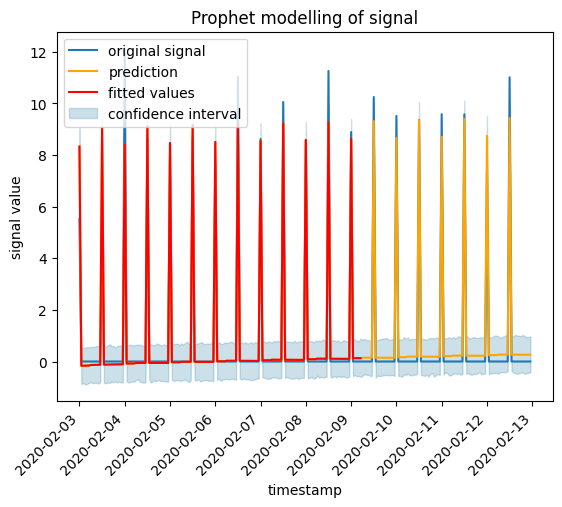

In [31]:
plot_prophet_results(df_impulses, 150, prophet_kwargs={"daily_seasonality":20})

Zeros in the data have a similar effect on applying a long range drift.

/tmp/ipykernel_89714/2873647724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_impulses_with_zeros["y"][100:150] = 0.0
00:01:59 - cmdstanpy - INFO - Chain [1] start processing
00:01:59 - cmdstanpy - INFO - Chain [1] done processing


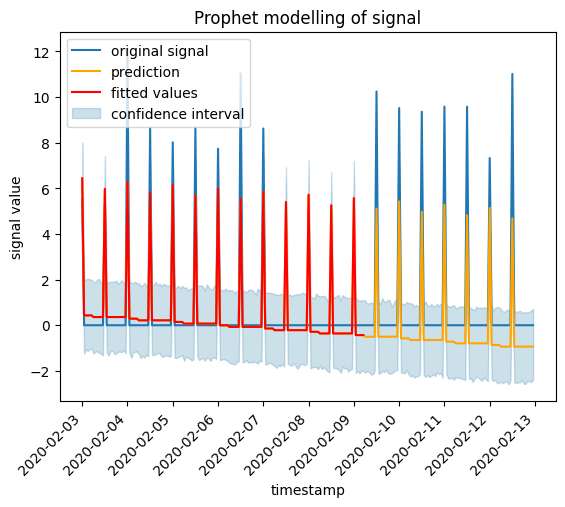

In [35]:
df_impulses_with_zeros = deepcopy(df_impulses)
df_impulses_with_zeros["y"][100:150] = 0.0

plot_prophet_results(df_impulses_with_zeros, 150, prophet_kwargs={"daily_seasonality":20})

/tmp/ipykernel_89714/2938550293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_impulses_with_zeros["y"][50:100] = 0.0
00:02:10 - cmdstanpy - INFO - Chain [1] start processing
00:02:10 - cmdstanpy - INFO - Chain [1] done processing


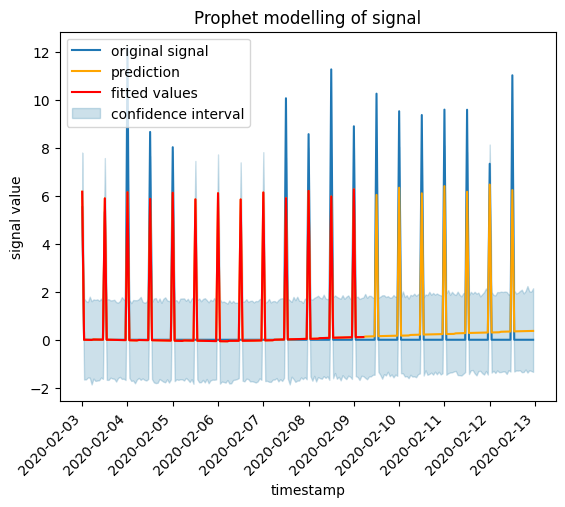

In [36]:
df_impulses_with_zeros = deepcopy(df_impulses)
df_impulses_with_zeros["y"][50:100] = 0.0

plot_prophet_results(df_impulses_with_zeros, 150, prophet_kwargs={"daily_seasonality":20})